In [1]:
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
images_directory = "data/resized_train_cropped/resized_train_cropped"

df_labels = pd.read_csv('data/trainLabels_cropped.csv')
images_names = sorted(df_labels.image.values) 

#### We have a huge skewness in distribition of the classes

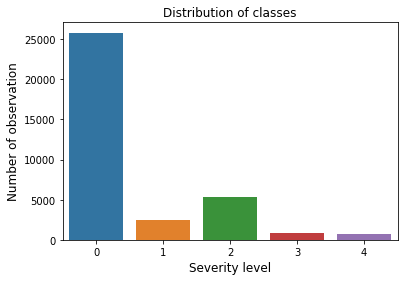

In [3]:
ys = df_labels.level.value_counts().values
xs = df_labels.level.value_counts().index
plt.rcParams["axes.labelsize"] = 12
fig = sns.barplot(x=xs, y=ys)
fig.set(xlabel='Severity level', ylabel='Number of observation', title="Distribution of classes")
plt.show()

#### We decided to cut our our data.
In each class there will be n observation. n is equal to the number of images in the smaller class

In [4]:
def stop_on_level(labels, level, number_in_smaller_class):
    first_n_indexes = []
    for ind, img_level in enumerate(labels):
        if len(first_n_indexes) == number_in_smaller_class:
            return first_n_indexes
        
        if img_level == level:
            first_n_indexes.append(ind)

def get_appropriate_indexes(classes=[0, 1, 2, 3, 4]):
    number_in_smaller_class = min(df_labels.level.value_counts()) 
    indexes = []
    for separate_level in classes:
        indexes_for_level = stop_on_level(labels=labels, level=separate_level,
                                      number_in_smaller_class=number_in_smaller_class)
        indexes += indexes_for_level
    return indexes

In [5]:
labels = [df_labels[df_labels['image'] == image_name].level.values[0] for image_name in images_names]
indexes = get_appropriate_indexes()

In [6]:
images_names = [images_names[i] for i in indexes]

### Preprocessing functions

In [7]:
def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
def get_severity(image_name):
    """
    Finds an appropriate observatiion by image name. Returns its image severity
    """
    return df_labels[df_labels['image'] == image_name].level.values[0]

def create_multilabels(severity):
    """
    Create a multilabel from severity level.
    severity: 0 -> multilabel: [1, 0, 0, 0, 0]
    severity: 1 -> multilabel: [1, 1, 0, 0, 0]
    ...
    severity: 4 -> multilabel: [1, 1, 1, 1, 1]
    """
    multi_label = [0, 0, 0, 0, 0]
    for i in range(severity+1):
        multi_label[i] = 1
    return multi_label

def get_image_array(path_to_image):
    """
    Return an resised array of an image.
    """
    image = cv2.imread(path_to_image)
    return image 
    
def get_images_and_labels():
    """
    Goes through all sorted images names. Return 3 arrays: images, labels and multilabels.
    Order of those 3 is the same, because images_names is sorted,
    so images[0], labels[0] and multi_labels[0] represent the same image
    """
    images = []
    labels = []
    multi_labels = []
    for filename in images_names:
        image_name = filename
        filename = filename + ".jpeg"
        path_to_img = os.path.join(images_directory, filename)
        
        image = get_image_array(path_to_img)
        images.append(image)
        
        label = get_severity(image_name)
        labels.append(label)
        
        multi_label = create_multilabels(label)
        multi_labels.append(multi_label)
        
    return np.array(images), np.array(labels), np.array(multi_labels)

In [8]:
images, labels, multi_labels = get_images_and_labels()

In [10]:
np.save("data/npy_files/images_arrays.npy", images)
np.save("data/npy_files/labels.npy", labels)
np.save("data/npy_files/multi_labels.npy", multi_labels)